In [55]:
import torch
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import copy

class GaiaDataset(Dataset):

    def __init__(self, dataset, cuts, preprocess=None):
        
        self.dataset = dataset
        self.cuts = cuts
        self.preprocess_methods = preprocess 
        self.summary_stats = None
        
        ''' data attributes:
            - target: fermi galaxy data
            - target_preprocessed:  fermi galaxy data with cuts and preprocessing
            - source: std gaussian noise
            - covariance: covariance matrix of fermi galaxy data
        '''

        self.get_target_data()
        self.get_covariance_data()
        self.get_target_data()

    def __getitem__(self, idx):
        output = {}
        output['target'] = self.target_preprocess[idx]
        output['source'] = self.source[idx]
        output['covariance'] = self.covariance[idx]
        return output

    def __len__(self):
        return self.target_preprocess.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_target_data(self):
        target = torch.tensor(np.load(self.dataset[0]), dtype=torch.float32)        
        target = PreProcessGaiaData(target, cuts=self.cuts, methods=self.preprocess_methods)
        target.apply_cuts()
        self.target = target.features.clone()
        target.preprocess()
        self.summary_stats = target.summary_stats
        self.target_preprocess = target.features.clone()

    def get_covariance_data(self):
        self.covariance = torch.tensor(np.load(self.dataset[1]), dtype=torch.float32)

    def get_source_data(self):
        self.source = torch.randn_like(self.target, dtype=torch.float32)

class PreProcessGaiaData:

    def __init__(self, 
                 data, 
                 cuts: dict={'r': None},
                 sun: list=[8.122, 0.0, 0.0208],
                 methods: list=None
                 ):
        
        self.features = data
        self.cuts = cuts 
        self.sun = torch.Tensor(sun)
        self.methods = methods
        self.summary_stats = {}

    def apply_cuts(self):
        ''' remove all stars with distance to sun farther than 'r' kiloparsecs
        '''
        r = torch.norm(self.features[..., :3] - self.sun, dim=-1)
        mask = r <= self.cuts['r'][1]
        self.features = self.features[mask]

    def preprocess(self):        
        #...preprocess with provided methods
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        else: pass
    
    def standardize(self,  sigma: float=1.0):
        """ standardize data to have zero mean and unit variance
        """
        self.summary_stats['mean'] = torch.mean(self.features, dim=0)
        self.summary_stats['std'] = torch.std(self.features, dim=0)
        self.features = (self.features - self.summary_stats['mean']) * (sigma / self.summary_stats['std'])

    def unit_ball_transform(self, c=1+1e-6):
        """ transform data do unit ball around galactic origin
        """
        r = torch.norm(self.features[..., :3] - self.sun, dim=-1)
        self.summary_stats['r_max'] = torch.max(r) * c
        self.features[..., :3] = (self.features[..., :3] - self.sun) / self.summary_stats['r_max']

    def radial_blowup(self):
        norm = torch.linalg.norm(self.features[..., :3], dim=-1, keepdims=True)
        self.features[...,:3] = (self.features[..., :3] / norm) * torch.atanh(norm)
        return self

class PostProcessGaiaData:

    def __init__(self, 
                 data, 
                 summary_stats,
                 sun: list=[8.122, 0.0, 0.0208],
                 methods: list=None
                 ):
        
        self.features = data
        self.sun = torch.Tensor(sun)
        self.summary_stats = summary_stats
        self.methods = methods

    def postprocess(self):
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Postprocessing method {} not implemented'.format(method))
        else: pass

    def inverse_standardize(self,  sigma: float=1.0):
        self.features = self.features * (self.summary_stats['std'] / sigma) + self.summary_stats['mean']
    
    def inverse_unit_ball_transform(self, c=1+1e-6):
        """ transform data do unit ball around galactic origin
        """
        r = torch.norm(self.features[..., :3] - self.sun, dim=-1)
        r_max = torch.max(r) * c
        self.features[..., :3] = self.features[..., :3] * self.summary_stats['r_max'] + self.sun

    def inverse_radial_blowup(self):
        norm = torch.linalg.norm(self.features[..., :3], dim=-1, keepdims=True)
        self.features[...,:3] = (self.features[..., :3] / norm) * torch.tanh(norm)


In [63]:
dat = ['../data/gaia/data.angle_340.smeared_00.npy', 
       '../data/gaia/data.angle_340.smeared_00.cov.npy']

preprocess=['unit_ball_transform', 'radial_blowup', 'standardize' ]
dataset =  GaiaDataset(dat, cuts={'r': [0.0, 2]}, preprocess=preprocess)
print(dataset.summary_stats)


{'r_max': tensor(2.0000), 'mean': tensor([-3.0443e-01,  2.5790e-02,  2.1364e-02,  8.8002e-01,  1.8771e+02,
        -2.5542e-01]), 'std': tensor([ 0.8145,  0.7980,  0.3973, 55.4950, 47.1590, 28.9456])}


### raw data

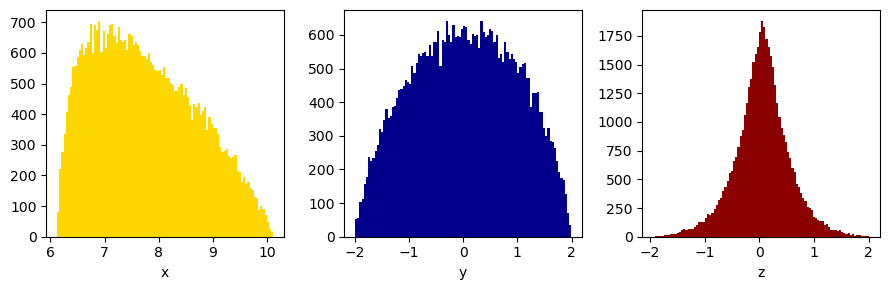

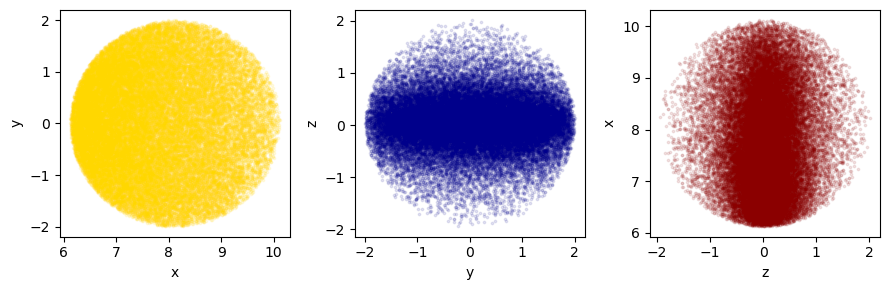

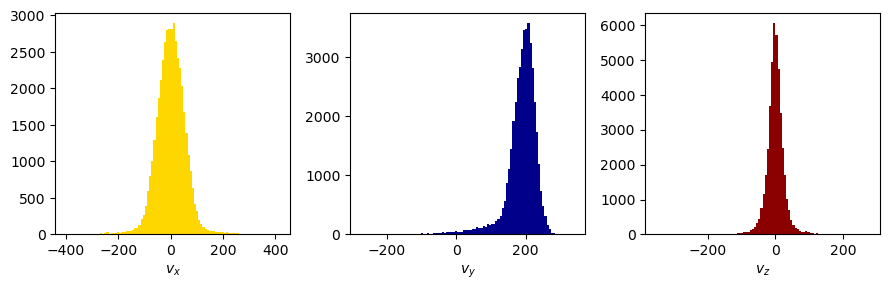

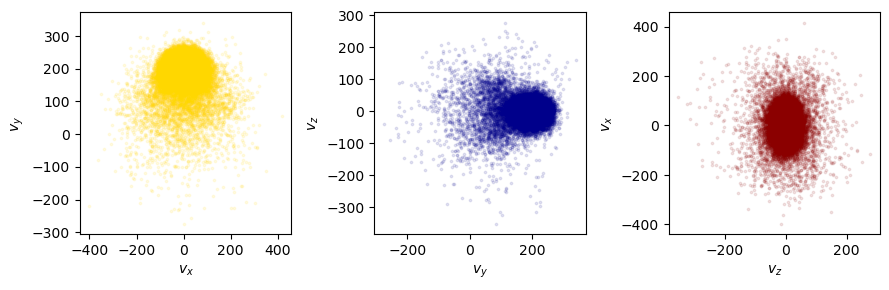

In [58]:
coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target[..., i], bins=100, color=color[i])
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target[:50000, i], dataset.target[:50000, j], s=3, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target[..., i+3], bins=100, color=color[i])
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target[:50000, i+3], dataset.target[:50000, j+3], s=3, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

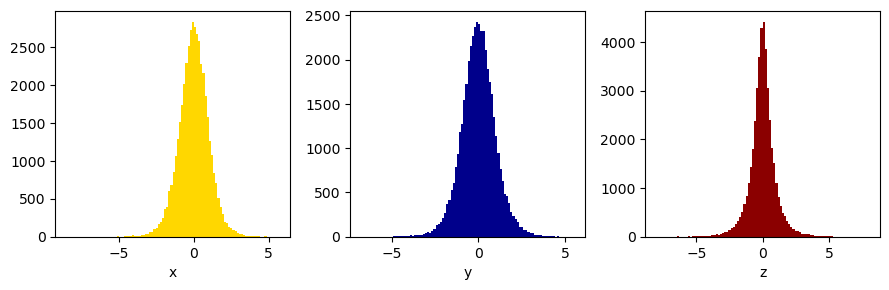

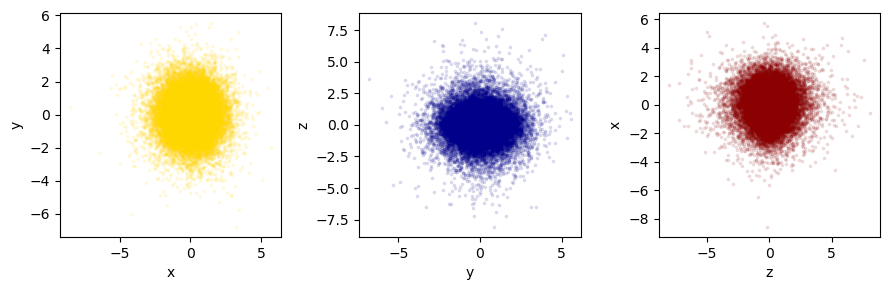

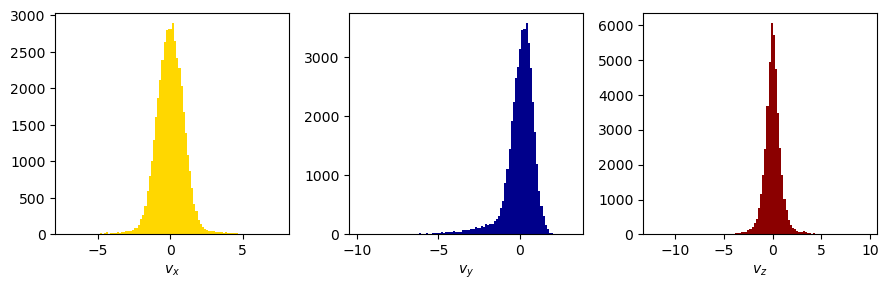

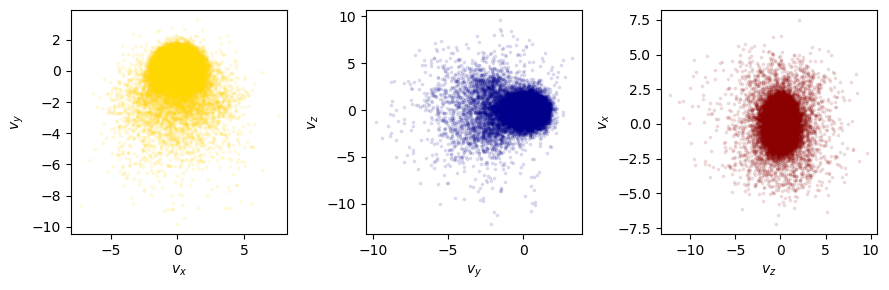

In [59]:
coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target_preprocess[..., i], bins=100, color=color[i])
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target_preprocess[:50000, i], dataset.target_preprocess[:50000, j], s=3, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target_preprocess[..., i+3], bins=100, color=color[i])
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target_preprocess[:50000, i+3], dataset.target_preprocess[:50000, j+3], s=3, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

## xcheck that post-processing works

In [60]:
data_post = PostProcessGaiaData(dataset.target_preprocess, 
                                summary_stats=dataset.summary_stats,
                                  methods=['inverse_standardize', 'inverse_radial_blowup', 'inverse_unit_ball_transform'])
data_post.postprocess()

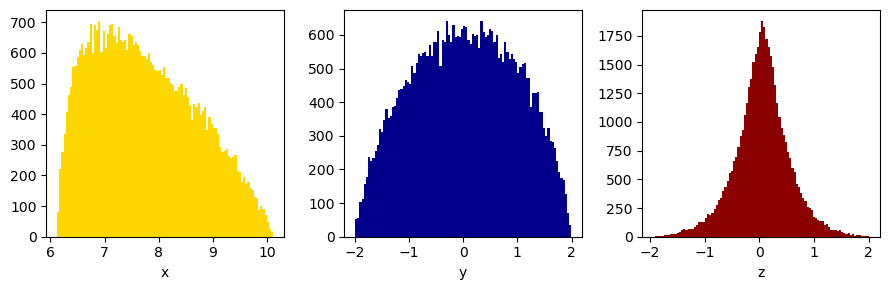

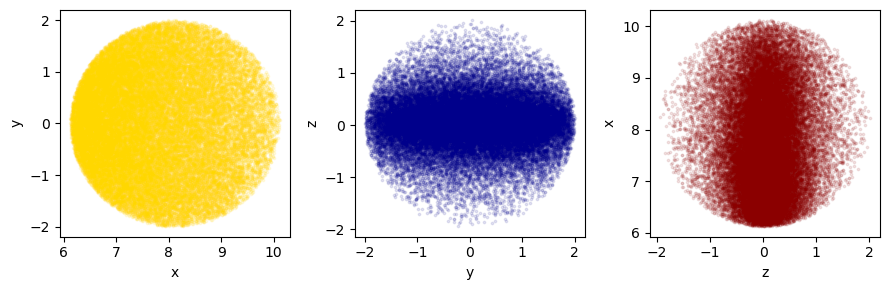

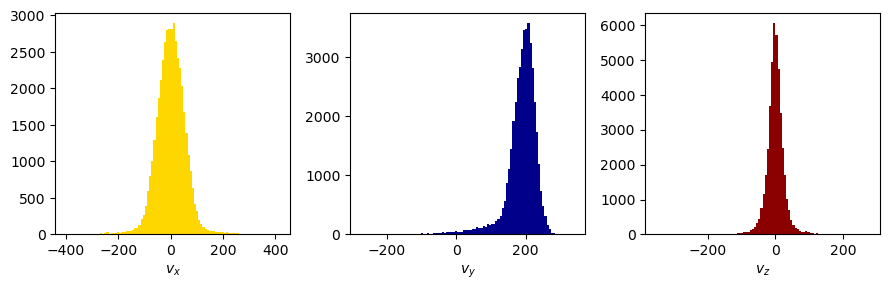

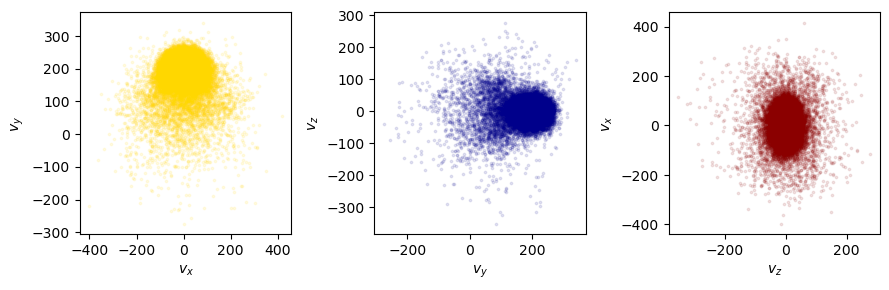

In [61]:
coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(data_post.features[..., i], bins=100, color=color[i])
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(data_post.features[:50000, i], data_post.features[:50000, j], s=3, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(data_post.features[..., i+3], bins=100, color=color[i])
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(data_post.features[:50000, i+3], data_post.features[:50000, j+3], s=3, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()